# 4 Pre-Processing Data and Training<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Introduction<a id='4.2_Introduction'></a>

In preceding notebooks, we performed preliminary assessments of data quality and refined the question to be answered. We determined that predicting market rent is the primary aim. That market rent can be applied to a Return-on-Investment calculation for each house for sale, determining whether or not that house would make a good investment on some ROI threshold. 

Before we can develop a predictive model, we need to encode categoricals, scale, and reduce dimensionality.

## 4.2 Imports<a id='4.3_Imports'></a>

In [191]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn import tree, metrics
from io import StringIO
from IPython.display import Image
import pydotplus
import datetime
import math

from library.sb_utils import save_file

## 4.3 Load Data<a id='4.4_Load_Data'></a>

In [192]:
corporate_data = pd.read_csv('../data/corporate_properties_values_Demo.csv')
corporate_data.head().T

,0,1,2,3,4
property_code,10000753,10000801,10000898,10000946,10001199
address,10627 Kittredge St,10705 Clermont St,10874 Fairfax Way,10944 Bellaire Way,11120 Sylvan Pl
city,Commerce City,Thornton,Thornton,Thornton,Parker
state,CO,CO,CO,CO,CO
zipcode,80022,80233,80233,80233,80138
beds,3,3,4,4,3
baths,2.5,2.0,2.0,2.0,2.0
sqft,1993,1544,1904,1800,1387
market_rent,2939.0,2529.0,2599.0,2485.0,2549.0
lat,39.88982,39.89058,39.89348,39.89548,39.51228


In [193]:
corporate_data.shape

(170, 22)

In [194]:
sale_data = pd.read_csv('../data/for_sale_Demo.csv')
sale_data.head().T

,0,1,2,3,4
address,5211 Willow Way,3547 S Ivanhoe Street,1128 S Jackson Street,2585 N Holly Street,1193 S Clarkson Street
city,Denver,Denver,Denver,Denver,Denver
zip,80238,80237,80210,80207,80210
beds,4.0,5.0,2.0,4.0,4.0
baths,4.0,4.0,2.0,2.0,2.0
sqft,2773,3269,1595,1795,2177
listPrice,750000,750000,750000,750000,750000
taxes,5431,2919,2935,2877,3038
lat,39.792285,39.651669,39.696093,39.754414,39.694933
lng,-104.886263,-104.922119,-104.943268,-104.922607,-104.978287


## 4.4 Manipulate Categorical Data <a id='4.5_Extract_Big_Mountain_Data'></a>

Let's start with the corporate owned properties. 
Because all of the properties are in Colorado, the state column doesn't add any information: let's remove it. The property_code is a unique, discrete piece of information used only by the property owner, with no relationship to the dependent variable, so let's remove that too. 

In [195]:
# Drop uninformative 'state' and 'property_code' columns
corporate_data = corporate_data.drop(['state', 'property_code'], axis=1)

Let's rename a couple of features so they make sense across dataframes. Rename 'estimatedValue' to 'value'. We will do the same on the other dataframe once we begin pre-processing it. 

In [196]:
# Rename two columns in corporate data df
cols = {'estimatedValue':'value'}
corporate_data = corporate_data.rename(columns=cols)

In [197]:
# rename sale_data columns
cols={'zip':'zipcode', 'listPrice':'value'}
sale_data = sale_data.rename(columns=cols)

The 'city' column doesn't add any information. Instead, let's use some information to categorize the cities by household income. Data for 2019 is available on the US Census site. Import that data, add to both the corporate_data and sale_data records, and we will set aside the city column before doing the test/train split. 

Additionally, the *name* of the district doesn't add any information. For each district, we have already gathered some information on the school lunch program (an indicator of poverty in the community), the rank of the schools within the district, and the racial demographics.

In [203]:
income = pd.read_csv('../data/City income.csv')
income_T = income.T

In [204]:
# manipulate income information to make compatible with a pd.concat
new_header = income_T.iloc[0] 
# take the rest of the data minus the header row
income_T = income_T[1:] 
# set the header row as the df header
income_T.columns = new_header 
income_T.rename(columns = {'Fact ':'City'}, inplace = True)

In [205]:
income_T.columns

Index(['Median household income (in 2019 dollars), 2015-2019', 'Per capita income in past 12 months (in 2019 dollars), 2015-2019'], dtype='object', name='Fact')

In [206]:
income_T.drop(['Per capita income in past 12 months (in 2019 dollars), 2015-2019'], axis=1, inplace=True)

In [207]:
# Let's see if there are any towns in the corporate_data set which are not included in the income data. 
no_data = corporate_data[~corporate_data['city'].isin(income_T.index)]
no_data.head()

,address,city,zipcode,beds,baths,sqft,market_rent,lat,lng,districtMatch,value,percentFreeDiscLunch,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofIndianStudents,percentofPacificIslanderStudents,percentofTwoOrMoreRaceStudents,percentofWhiteStudents,rankMovement
6,11375 Nome St,Henderson,80640,4,2.0,2087,2595.0,39.90208,-104.85186,Brighton 27J School District,471589.95,44.03,2.20,2.92,53.74,0.31,0.17,3.00,37.65,-48.06
59,11620 Oakland Dr,Henderson,80640,3,1.5,1420,2339.0,39.90825,-104.84968,Brighton 27J School District,425300.00,44.03,2.20,2.92,53.74,0.31,0.17,3.00,37.65,-48.06
97,11798 W Marlowe Ave,Morrison,80465,4,2.5,2404,2933.0,39.63200,-105.12900,Jefferson County R-1 School District,430457.50,37.16,1.45,2.89,26.14,0.62,0.14,4.07,64.70,-23.29


The houses in Henderson are actually in Commerce City. This is a quirk of Denver-metro addresses. Morrison is a tiny area, so there isn't any data available for it. The closest town to Morrison is Golden. Let's map these in both the corporate and sales data. 

In [208]:
dict1 = {'Henderson':'Commerce City', 'Morrison':'Golden'}
corporate_data.loc[corporate_data['city'].isin(dict1.keys()), 'city'] = corporate_data['city'].map(dict1)

In [209]:
# Let's see if there is any sales data that doesn't have income information. 
no_data = sale_data[~sale_data['city'].isin(income_T.index)]

In [210]:
no_data['city'].unique()

array(['Morrison', 'Indian Hills', 'Idledale'], dtype=object)

All of these little hamlets are near Golden, so let's map them to Golden. 

In [211]:
dict2={'Morrison':'Golden', 'Indian Hills':'Golden', 'Idledale':'Golden'}
sale_data.loc[sale_data['city'].isin(dict1.keys()), 'city'] = sale_data['city'].map(dict1)

In [212]:
corporate_data_I = corporate_data.merge(income_T, left_on='city', right_on=income_T.index)
corporate_data_I.shape, corporate_data.shape

((170, 21), (170, 20))

In [213]:
sale_data_I = sale_data.merge(income_T, left_on='city', right_on=income_T.index)

We have a problem with the HOA data. Some of the deployment data (houses for sale) have HOAs, but we don't have any information about whether the corporate properties have an HOA. So, we have no way to scale that data.
One way to handle this is to combine the HOA price into the value of the house, over 30 years. Let's do that with the sales_data. 

In [214]:
sale_data_I['value'] = sale_data_I['value'] + (sale_data_I['monthly_hoa'] * 12)
sale_data_I.drop(['monthly_hoa'], axis=1, inplace=True)

We have taxes for the sale data, because it is included in the listing. But, it is linearly related to the value of the house, because taxes are calculated as a percentage of the house's value. Therefore, instead of *adding* tax data for the corporate-owned houses, we shall remove the tax data from the sale houses. 

In [215]:
# drop tax column because it's linearly related to sales price (percentage of sales price)
sale_data_I.drop('taxes', axis=1, inplace=True)

'Beds' and 'baths' should be categorical columns, since these are inherently categorical. Change the data types of these columns.

In [216]:
corporate_data_I['beds'] = pd.Categorical(corporate_data_I.beds)
corporate_data_I['baths'] = pd.Categorical(corporate_data_I.baths)
sale_data_I['beds'] = pd.Categorical(sale_data_I.beds)
sale_data_I['baths'] = pd.Categorical(sale_data_I.baths)

In [217]:
# Encode categorical features with dummies, dropping one to avoid instability
dummy_features_corp = pd.get_dummies(corporate_data_I[['beds', 'baths']], drop_first=True)
dummy_features_sale = pd.get_dummies(sale_data_I[['beds', 'baths']], drop_first=True)

# Concat dummy_features to original dfs
corporate_data_I = pd.concat([corporate_data_I, dummy_features_corp], axis=1)
sale_data_I = pd.concat([sale_data_I, dummy_features_sale], axis=1)

In [218]:
sale_data_I.columns, corporate_data_I.columns

(Index(['address', 'city', 'zipcode', 'beds', 'baths', 'sqft', 'value', 'lat',
        'lng', 'districtMatch', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement',
        'Median household income (in 2019 dollars), 2015-2019', 'beds_2.0',
        'beds_3.0', 'beds_4.0', 'beds_5.0', 'beds_6.0', 'beds_7.0', 'beds_9.0',
        'baths_2.0', 'baths_3.0', 'baths_4.0', 'baths_7.0'],
       dtype='object'),
 Index(['address', 'city', 'zipcode', 'beds', 'baths', 'sqft', 'market_rent',
        'lat', 'lng', 'districtMatch', 'value', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',


In [219]:
# Check datatype of new column
corporate_data_I['Median household income (in 2019 dollars), 2015-2019'].dtypes

dtype('O')

In [220]:
corporate_data_I[['Median household income (in 2019 dollars), 2015-2019']] = \
        corporate_data_I[['Median household income (in 2019 dollars), 2015-2019']].replace('[\$,]','',regex=True).astype(float)

In [221]:
sale_data_I[['Median household income (in 2019 dollars), 2015-2019']] = \
        sale_data_I[['Median household income (in 2019 dollars), 2015-2019']].replace('[\$,]','',regex=True).astype(float)

## 4.5 Train/Test Split - Keep Value<a id='4.6_Train/Test_Split'></a>

After a couple of preliminary models, it seems that the 'value' of a property is tied to other features, possible some of which we have included in our particular set of features. 
First, we will run machine learning models including the feature 'value', then run without, and see which gives us a better outcome (explains more of the variability in data). 

So, let's use a 90/10 train/test split within the corporate data, using 'market_rent' as the dependent variable. 

In [538]:
# use train_test_split 
X_train, X_test, y_train, y_test = train_test_split(corporate_data_I.drop(columns='market_rent'), 
                                                    corporate_data_I.market_rent, test_size=0.1, 
                                                    random_state=42)

In [539]:
X_train.shape, X_test.shape

((153, 29), (17, 29))

In [540]:
y_train.shape, y_test.shape

((153,), (17,))

In [541]:
#Save the 'address' and 'zipcode' columns from the train/test data into address_train
# and address_train
#Then drop those columns from `X_train` and `X_test`. Use 'inplace=True'
address_list = ['address', 'zipcode', 'lat', 'lng', 'districtMatch', 'city', 'beds', 'baths']
address_train = X_train[address_list]
address_test = X_test[address_list]
X_train.drop(columns=address_list, inplace=True)
X_test.drop(columns=address_list, inplace=True)
X_train.shape, X_test.shape

((153, 21), (17, 21))

In [542]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

sqft                                                      int64
value                                                   float64
percentFreeDiscLunch                                    float64
percentofAfricanAmericanStudents                        float64
percentofAsianStudents                                  float64
percentofHispanicStudents                               float64
percentofIndianStudents                                 float64
percentofPacificIslanderStudents                        float64
percentofTwoOrMoreRaceStudents                          float64
percentofWhiteStudents                                  float64
rankMovement                                            float64
Median household income (in 2019 dollars), 2015-2019    float64
beds_3                                                    uint8
beds_4                                                    uint8
beds_5                                                    uint8
baths_1.5                               

In [543]:
#Repeat this check for the test split in `X_test`
X_test.dtypes

sqft                                                      int64
value                                                   float64
percentFreeDiscLunch                                    float64
percentofAfricanAmericanStudents                        float64
percentofAsianStudents                                  float64
percentofHispanicStudents                               float64
percentofIndianStudents                                 float64
percentofPacificIslanderStudents                        float64
percentofTwoOrMoreRaceStudents                          float64
percentofWhiteStudents                                  float64
rankMovement                                            float64
Median household income (in 2019 dollars), 2015-2019    float64
beds_3                                                    uint8
beds_4                                                    uint8
beds_5                                                    uint8
baths_1.5                               

All features in X are numeric.

## 4.6 Trim Data (Train set includes 'values') <a id='4.6 Trim Data(Train set includes "values")'></a>

 Let's look at the distributions of the training data. 

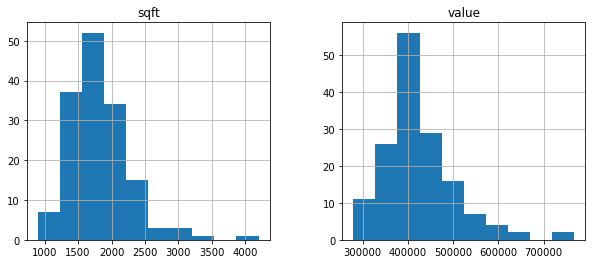

In [544]:
X_train[['sqft', 'value']].hist(figsize=(10,4))
plt.show()

Graphically, it looks like there are a couple on the end - but these may not be outliers really, but rather large houses that are worth a lot of money. More data may prove these to be not outliers at all. We believe that there are more houses in the smaller, less expensive range and fewer in the larger, more expensive range *in general* and that houses smaller than about 1000 square feet are quite rare, leading to this distribution. 
We choose to not trim these data points as they are representative of the pattern as a whole. 

## 4.7 Initial Modeling - Dummy Regressor (including 'value')

First, let's try the most basic model - the mean. This will give us some basis for comparison of the rest of the work we do. 

In [545]:
# Fit the Dummy Regressor on the training data
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[2550.28104575]])

In [546]:
# Predict outcome on X_train
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([2550.28104575, 2550.28104575, 2550.28104575, 2550.28104575,
       2550.28104575])

In [547]:
# Predict outcome on X_test
y_te_pred = dumb_reg.predict(X_test)
y_te_pred[:5]

array([2550.28104575, 2550.28104575, 2550.28104575, 2550.28104575,
       2550.28104575])

### 4.7.1 Metrics on Dummy Regressor<a id='4.7.1_Metrics'></a>

#### 4.7.1.1 R-squared, or coefficient of determination of Dummy Model<a id='4.7.1.1_R-squared,_or_coefficient_of_determination'></a>

The R-squared of the dummy regressor should be 0 by definition. It will not be zero for the test set. 

In [548]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.18676089981796995)

#### 4.7.1.2 Mean Absolute Error of Dummy Model<a id='4.7.1.1_R-squared,_or_coefficient_of_determination'></a>

As a reminder, the mean absolute error is the average of the absolute errors. 

In [549]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(189.14520056388568, 145.17839292579782)

#### 4.7.1.3 Mean Squared Error of Dummy Model<a id='4.7.1.1_R-squared,_or_coefficient_of_determination'></a>

Another reminder: the mean squared error is the average of the squares of the errors. 

In [550]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(63398.04519629201, 31410.637233542668)

## 4.8 Scaling Test/Train (with 'value')<a id='4.8_Initial_Models'></a>

Our data is on different scales. For example, square footage is in the thousands, while percentage of kids receiving school lunch is necessarily under 100. The dummy variables are either 0 or 1. Let's scale the features that are not binary. 

In [551]:
X_train.columns, X_test.columns

(Index(['sqft', 'value', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement',
        'Median household income (in 2019 dollars), 2015-2019', 'beds_3',
        'beds_4', 'beds_5', 'baths_1.5', 'baths_2.0', 'baths_2.5', 'baths_3.0',
        'baths_3.5', 'baths_4.0'],
       dtype='object'),
 Index(['sqft', 'value', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement',
        'Median household income (in 2019 dollars), 2015-2019', 'beds_3',
        'beds_4', 'beds_5', 'baths_1.5', 'baths_2.0', 'baths_2.5', 'baths_3.0',
        'ba

In [552]:
#Call the StandardScaler`s fit method on `X_train` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_train` and `X_test`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
col_list = ['sqft', 'value','percentFreeDiscLunch', 'percentofAfricanAmericanStudents',
       'percentofAsianStudents', 'percentofHispanicStudents',
       'percentofIndianStudents', 'percentofPacificIslanderStudents',
       'percentofTwoOrMoreRaceStudents', 'percentofWhiteStudents',
       'rankMovement', 'Median household income (in 2019 dollars), 2015-2019']
scaled_features = X_train.copy()
features = scaled_features[col_list]
scaler.fit(features.values)
features = scaler.transform(features.values)



In [553]:
# transform back to df
scaled_features[col_list] = features
X_tr_scaled = scaled_features.copy()

In [554]:
# transform test set
scaled_te_features = X_test.copy()
features = scaled_te_features[col_list]
features = scaler.transform(features.values)
scaled_te_features[col_list] = features
X_te_scaled = scaled_te_features.copy()

In [555]:
X_tr_scaled.columns, X_te_scaled.columns

(Index(['sqft', 'value', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement',
        'Median household income (in 2019 dollars), 2015-2019', 'beds_3',
        'beds_4', 'beds_5', 'baths_1.5', 'baths_2.0', 'baths_2.5', 'baths_3.0',
        'baths_3.5', 'baths_4.0'],
       dtype='object'),
 Index(['sqft', 'value', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement',
        'Median household income (in 2019 dollars), 2015-2019', 'beds_3',
        'beds_4', 'beds_5', 'baths_1.5', 'baths_2.0', 'baths_2.5', 'baths_3.0',
        'ba

## 4.9 Initial Model - Linear Regression (with 'value')<a id='4.8_Initial_Models'></a>

The first model we will run is the default Linear Regression model. We don't need to use the scaled data with Linear Regression (or, we can - it makes no difference). Let's use the unscaled data so that, if necessary, we can interpret the coefficients. 

In [556]:
# Instantiate the model and fit to training data
lm = LinearRegression().fit(X_train, y_train)
print(X_train.shape)
print(len(lm.coef_))

(153, 21)
21


##### 4.9.1 Make predictions using the model on both train and test splits

In [557]:
#Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
#Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
y_tr_pred = lm.predict(X_train)
y_te_pred = lm.predict(X_test)

In [558]:
# r^2 - train, test
lm_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
lm_r2

(0.7612988034112752, 0.23381348873786156)

Here we see that our simple linear regression model explains over 70% of the variance on the train set but only 23% on the test set. The much lower value for the test set suggests overfitting. This isn't a surprise because we have a high dimensionality and haven't accounted for that in any way.  

In [559]:
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(90.39676046917954, 110.7935350431681)

This is much better than simply using the mean. For the Dummy Regressor model, the MAE of the test set was 145. This is 110. 

In [560]:
pipe = make_pipeline( 
    SelectKBest(f_regression),
    LinearRegression()
)

In [561]:
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe.fit(X_train, y_train)

Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x000001D51D4995E0>)),
                ('linearregression', LinearRegression())])

In [562]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [563]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.6917943188273797, 0.4463482575999346)

In [564]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(105.87982220264948, 88.69542185918435)

This improves upon the default linear regression model. The default number of *k* is 10. Perhaps we can do better after checking the best value for k. 

In [565]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'linearregression', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [566]:
# build grid of hyperparameters
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
print(grid_params)

{'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]}


In [567]:
# We can use GridSearchCV because linear regression is very fast and we're only checking one hyperparameter
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [568]:
# fit the model with cv=5
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001D51D4995E0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21]})

In [569]:
# Find the best scores
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [570]:
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 19}

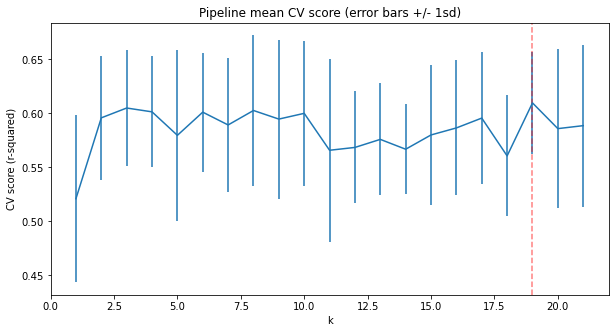

In [571]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [572]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
print(selected)

[ True  True  True  True False  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True]


In [573]:
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

baths_4.0                                                466.213068
baths_2.5                                                365.061884
baths_3.5                                                317.391049
baths_2.0                                                298.552436
baths_3.0                                                291.714088
baths_1.5                                                171.639154
beds_5                                                   149.597964
beds_3                                                    94.958348
beds_4                                                    82.631930
percentFreeDiscLunch                                      33.590312
rankMovement                                               2.640386
sqft                                                       0.315461
value                                                      0.000936
Median household income (in 2019 dollars), 2015-2019       0.000836
percentofWhiteStudents                          

## 4.10 Random Forest Model<a id='4.10_Random_Forest_Model'></a>

First, let's try Random Forest Regressor with default hyperparameters, using the scaled data which include the 'value' feature. 


In [574]:
# Instantiate the model and fit it to scaled training data
rf_default = RandomForestRegressor(random_state=42)
rf_default.fit(X_tr_scaled, y_train)

RandomForestRegressor(random_state=42)

In [575]:
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(rf_default, X_tr_scaled, y_train, cv=5)

In [576]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.38169794, 0.44723863, 0.57238272, 0.60059676, 0.64220459])

In [577]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.5288241280301604, 0.09818971749809279)

## 4.11 Hyperparameter search using RandomSearchCV<a id='4.10_Random_Forest_Model'></a>

Let's try some hyperparameters and see if we can improve upon the default random forest regressor. 

In [578]:
# Build param grid for random search
n_est = [10, 50, 100, 500, 1000, 1200, 1500]
max_features = ['auto', 'sqrt']
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
min_samples_split = [2, 5, 10, 15, 20, 25, 30, 35, 40]
min_samples_leaf = [1, 2, 5, 10, 15, 20]

random_grid = {
        'bootstrap': [True, False],
        'n_estimators': n_est,
        'max_depth': max_depth,
        'max_features': max_features,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'criterion': ["mse", "mae"]
}
random_grid

{'bootstrap': [True, False],
 'n_estimators': [10, 50, 100, 500, 1000, 1200, 1500],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 35, 40],
 'min_samples_leaf': [1, 2, 5, 10, 15, 20],
 'criterion': ['mse', 'mae']}

In [579]:
# Call RandomizedSearchCV with RandomForestRegressor, the random_grid, and cv=5
rf = RandomForestRegressor(random_state=42)
rf_random_cv = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                                  cv=5, n_jobs=-1)

In [580]:
#Now call the `RandomizedSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_random_cv.fit(X_tr_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['mse', 'mae'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10, 15,
                                                             20],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              25, 30, 35, 40],
                                        'n_estimators': [10, 50, 100, 500, 1000,
                                                         1200, 1500]})

In [581]:
#Print the best params (`best_params_` attribute) from the grid search
rf_random_cv.best_params_

{'n_estimators': 1000,
 'min_samples_split': 20,
 'min_samples_leaf': 10,
 'max_features': 'auto',
 'max_depth': 70,
 'criterion': 'mse',
 'bootstrap': True}

In [582]:
rf_best_cv_results = cross_validate(rf_random_cv.best_estimator_, X_tr_scaled, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.32693407, 0.55520105, 0.50907008, 0.59402934, 0.61133764])

In [583]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.5193144380016406, 0.10242420379106468)

With the hyperparameters, we have improved upon the default Cross-Validation scores. 

Text(0.5, 1.0, 'Best random forest regressor feature importances')

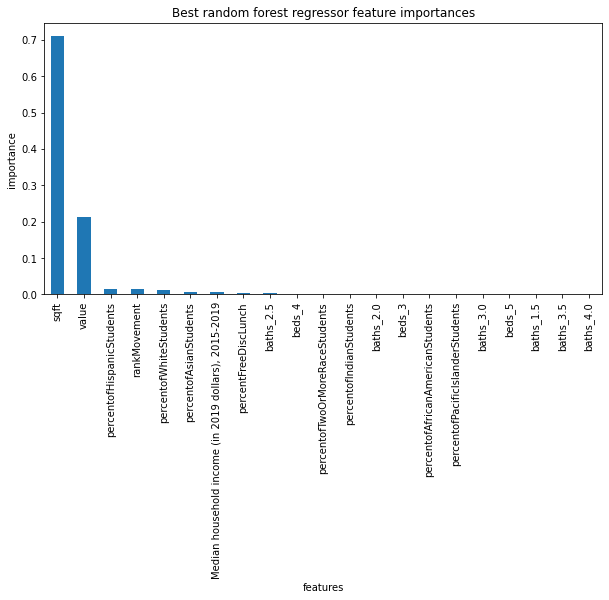

In [584]:
#Code task 27#
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_random_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(10, 5))
imps = rf_random_cv.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_tr_scaled.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances')

## 4.12 Metrics - Comparing models<a id='4.10_Random_Forest_Model'></a>

#### 4.12.1 Linear Regression Model Performance

In [585]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [586]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(114.24764749332537, 12.905779063902868)

In [587]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

115.74326173788931

In [588]:
std_from_estimate = (mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)) - lr_mae_mean)/lr_mae_std
std_from_estimate

0.11588717249523768

#### 4.12.2 Random Forest Model Performance

In [589]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
rf_neg_mae = cross_validate(rf_random_cv.best_estimator_, X_tr_scaled, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [590]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(124.83695897891009, 22.603958102418666)

In [591]:
mean_absolute_error(y_test, rf_random_cv.best_estimator_.predict(X_te_scaled)), mean_absolute_error(y_train, rf_random_cv.best_estimator_.predict(X_tr_scaled))

(105.05414233668395, 104.17957863373556)

In [592]:
std_from_estimate = (mean_absolute_error(y_test, rf_random_cv.best_estimator_.predict(X_te_scaled)) - rf_mae_mean)/rf_mae_std
std_from_estimate

-0.8751925902795467

#### 4.12.3 Conclusion

The random forest model has a lower cross-validation mean absolute error by about 15 dollars. Verifying performance on the test set produces performance consistent with the cross-validation results.

## 4.13 Data quantity assessment<a id='4.12_Data_quantity_assessment'></a>

In [596]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_tr_scaled, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

C:\Users\macef\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\macef\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\macef\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\macef\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\macef\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\macef\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value e

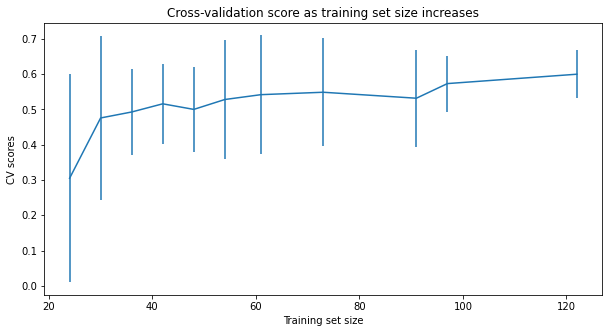

In [597]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

Finally, do we need to acquire more data? Would more data be useful? Gathering more data using the methods we have at our disposal takes time. Assess this trade off by seeing how performance varies with differing data set sizes. The `learning_curve` function does this conveniently.

We have plenty of data according to this chart. 

## 4.14 Save best model object from pipeline<a id='4.13_Save_best_model_object_from_pipeline'></a>

In [599]:
#Assign the pandas version number (`pd.__version__`) to the `pandas_version` attribute,
#the numpy version (`np.__version__`) to the `numpy_version` attribute,
#the sklearn version (`sklearn_version`) to the `sklearn_version` attribute,
#and the current datetime (`datetime.datetime.now()`) to the `build_datetime` attribute
#Let's call this model version '1.0'
best_model = rf_random_cv.best_estimator_
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [600]:
# save the model

modelpath = '../models'
save_file(best_model, 'market_rent_model.pkl', modelpath)

Writing file.  "../models\market_rent_model.pkl"
